# Чтение и обработка данных

In [1]:
# Выбираем нужные категории
hobbies = ['History',
           'Psychology',
           'Politics',
           'Mathematics',
           'Physics',
           'Internet',
           'PC',
           'Economy Management',
           'Biology',
           'Chemistry',
           'Reading',
           'Geography',
           'Foreign languages',
           'Medicine',
           'Law',
           'Cars',
           'Art exhibitions',
           'Religion',
           'Countryside, outdoors',
           'Dancing',
           'Musical instruments',
           'Writing',
           'Passive sport',
           'Active sport',
           'Gardening',
           'Celebrities',
           'Shopping',
           'Science and technology',
           'Theatre',
           'Fun with friends',
           'Adrenaline sports',
           'Pets',
          ]

personality = ['Daily events',
               'Prioritising workload',
               'Writing notes',
               'Workaholism',
               'Thinking ahead',
               'Final judgement',
               'Reliability',
               'Keeping promises',
               'Loss of interest',
               'Friends versus money',
               'Funniness',
               'Fake',
               'Criminal damage',
               'Decision making',
               'Elections',
               'Self-criticism',
               'Judgment calls',
               'Hypochondria',
               'Empathy',
               'Eating to survive',
               'Giving',
               'Compassion to animals',
               'Borrowed stuff',
               'Loneliness',
               'Cheating in school',
               'Health',
               'Changing the past',
               'God',
               'Dreams',
               'Charity',
               'Number of friends',
               'Punctuality',
               'Lying',
               'Waiting',
               'New environment',
               'Mood swings',
               'Appearence and gestures',
               'Socializing',
               'Achievements',
               'Responding to a serious letter',
               'Children',
               'Assertiveness',
               'Getting angry',
               'Knowing the right people',
               'Public speaking',
               'Unpopularity',
               'Life struggles',
               'Happiness in life',
               'Energy levels',
               'Small - big dogs',
               'Personality',
               'Finding lost valuables',
               'Getting up',
               'Interests or hobbies',
               "Parents' advice",
               'Questionnaires or polls',
               'Internet usage',
               ]

In [2]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

from sklearn.model_selection import train_test_split as train
from skmultilearn.model_selection import iterative_train_test_split as it_train
from skmultilearn.model_selection import IterativeStratification

from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

from sklearn.metrics.pairwise import cosine_distances

from joblib import dump

In [3]:
# Чтение данных и замена категориальных значений
df = pd.read_csv('datasets_117_1001_responses.csv')

df['Smoking'].replace(to_replace=['never smoked', 
                                  'tried smoking', 
                                  'former smoker', 
                                  'current smoker'], 
                      value=[1.0, 
                             2.0, 
                             3.0, 
                             4.0], 
                      inplace=True)
df['Alcohol'].replace(to_replace=['drink a lot', 
                                  'social drinker', 
                                  'never'], 
                      value=[3.0, 
                             2.0, 
                             1.0], 
                      inplace=True)
df['Punctuality'].replace(to_replace=['i am always on time', 
                                      'i am often early', 
                                      'i am often running late'], 
                      value=[3.0, 
                             2.0, 
                             1.0], 
                      inplace=True)
df['Lying'].replace(to_replace=['never', 
                                'only to avoid hurting someone', 
                                'sometimes', 
                                'everytime it suits me'], 
                      value=[1.0, 
                             2.0, 
                             3.0, 
                             4.0], 
                      inplace=True)
df['Internet usage'].replace(to_replace=['most of the day', 
                                         'few hours a day', 
                                         'less than an hour a day', 
                                         'no time at all'], 
                      value=[4.0, 
                             3.0, 
                             2.0, 
                             1.0], 
                      inplace=True)
df['Gender'].replace(to_replace=['female', 
                                 'male'], 
                      value=[1.0, 
                             2.0], 
                      inplace=True)
df['Left - right handed'].replace(to_replace=['right handed', 
                                              'left handed'], 
                      value=[1.0, 
                             2.0], 
                      inplace=True)
df['Education'].replace(to_replace=
                        ['currently a primary school pupil', 
                         'primary school', 
                         'secondary school', 
                         'college/bachelor degree', 
                         'masters degree', 
                         'doctorate degree'], 
                      value=[1.0, 
                             2.0, 
                             3.0, 
                             4.0, 
                             5.0, 
                             6.0], 
                      inplace=True)
df['Only child'].replace(to_replace=['no', 
                                     'yes'], 
                      value=[1.0, 
                             2.0], 
                      inplace=True)
df['Village - town'].replace(to_replace=['village', 
                                         'city'], 
                      value=[1.0, 
                             2.0], 
                      inplace=True)
df['House - block of flats'].replace(to_replace=['block of flats', 
                                                 'house/bungalow'], 
                      value=[1.0, 
                             2.0], 
                      inplace=True)

In [4]:
# Заполняем NaN'ы
# Для возраста, роста, веса используем округленное 
# среднее значение по столбцу,
# для целевых признаков (хобби) заполняем пропуски 
# единицей,
# а для остальных признаков - самое частое значение
for column in ['Age', 'Height', 'Weight']:
    df[column].fillna(np.around(df[column].mean()), inplace=True)
    
df[hobbies] = df[hobbies].fillna(1)

df.fillna(df.mode().iloc[0], inplace=True)

# Анализ и подготовка данных

In [5]:
# Считаем корреляции между целевыми признаками и
# признаками, выбранными для предсказания
df_compare = df[personality].join(df[hobbies])
cor = df_compare.corr(method='pearson')

# Выводим два самых коррелирующих и 
# обратно коррелирующих признака для
# каждого хобби
for p in personality:
    correlations = cor[p][hobbies].sort_values()
    print(correlations[:2].append(correlations[-2:]))
    print()

Chemistry               -0.074630
Countryside, outdoors   -0.055817
Law                      0.271804
Politics                 0.465930
Name: Daily events, dtype: float64

Internet           -0.071699
Fun with friends   -0.060845
Mathematics         0.110552
Gardening           0.146120
Name: Prioritising workload, dtype: float64

Passive sport     -0.098786
Cars              -0.088056
Art exhibitions    0.181708
Dancing            0.184453
Name: Writing notes, dtype: float64

Celebrities              -0.100145
Passive sport            -0.074057
Science and technology    0.189832
Reading                   0.202455
Name: Workaholism, dtype: float64

Fun with friends         -0.091569
Passive sport            -0.061891
History                   0.127791
Science and technology    0.129840
Name: Thinking ahead, dtype: float64

Adrenaline sports   -0.069595
Active sport        -0.058387
Dancing              0.156023
Religion             0.285769
Name: Final judgement, dtype: float64

Passiv

In [6]:
# Функция для вывода отчета о различных оценках 
# классификатора на тестовых данных
def report_classifier(clf, X_train, y_train, X_test, y_test):
    
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    
    recall_sum = 0
    precision_sum = 0
    accuracy_sum = 0
    min_rec = 2.0
    max_rec = -2.0
    min_pre = 2.0
    max_pre = -2.0
    min_acc = 2.0
    max_acc = -2.0

    for truth, prediction in zip(y_test, predictions):
        report = classification_report(truth, 
                                       prediction, 
                                       output_dict=True, 
                                       zero_division=0)
        if type(report.get('1.0')) == dict:
            min_rec = min(min_rec, report['1.0']['recall'])
            max_rec = max(max_rec, report['1.0']['recall'])
            min_pre = min(min_pre, report['1.0']['precision'])
            max_pre = max(max_pre, report['1.0']['precision'])
            recall_sum += report['1.0']['recall']
            precision_sum += report['1.0']['precision']
        min_acc = min(min_acc, report['accuracy'])
        max_acc = max(max_acc, report['accuracy'])
        accuracy_sum += report['accuracy']

    print('avg recall', recall_sum / y_test.shape[0])
    print('avg precision', precision_sum / y_test.shape[0])
    print('avg accuracy', accuracy_sum / y_test.shape[0])
    print()
    print('min recall', min_rec)
    print('max recall', max_rec)
    print()
    print('min precision', min_pre)
    print('max precision', max_pre)
    print()
    print('min accuracy', min_acc)
    print('max accuracy', max_acc)

In [7]:
# Функция для вывода отчета о различных оценках 
# классификатора на тестовых данных (0 принимается за положительный класс)
def report_classifier_neg(clf, X_train, y_train, X_test, y_test):
    
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    
    recall_sum = 0
    precision_sum = 0
    accuracy_sum = 0
    min_rec = 2.0
    max_rec = -2.0
    min_pre = 2.0
    max_pre = -2.0
    min_acc = 2.0
    max_acc = -2.0

    for truth, prediction in zip(y_test, predictions):
        report = classification_report(truth, 
                                       prediction, 
                                       output_dict=True, 
                                       zero_division=0)
        if type(report.get('0.0')) == dict:
            min_rec = min(min_rec, report['0.0']['recall'])
            max_rec = max(max_rec, report['0.0']['recall'])
            min_pre = min(min_pre, report['0.0']['precision'])
            max_pre = max(max_pre, report['0.0']['precision'])
            recall_sum += report['0.0']['recall']
            precision_sum += report['0.0']['precision']
        min_acc = min(min_acc, report['accuracy'])
        max_acc = max(max_acc, report['accuracy'])
        accuracy_sum += report['accuracy']

    print('avg recall', recall_sum / y_test.shape[0])
    print('avg precision', precision_sum / y_test.shape[0])
    print('avg accuracy', accuracy_sum / y_test.shape[0])
    print()
    print('min recall', min_rec)
    print('max recall', max_rec)
    print()
    print('min precision', min_pre)
    print('max precision', max_pre)
    print()
    print('min accuracy', min_acc)
    print('max accuracy', max_acc)

In [8]:
# Функция для вывода отчета о различных оценках 
# на тестовых данных для подхода с нахождением
# похожих пользователей косинусным расстоянием
def report_similarity(X_train, y_train, X_test, y_test, k=100):

    user_similarity = cosine_distances(X_test, X_train)

    recall_sum = 0
    precision_sum = 0
    accuracy_sum = 0
    min_rec = 2.0
    max_rec = -2.0
    min_pre = 2.0
    max_pre = -2.0
    min_acc = 2.0
    max_acc = -2.0

    for user_ind in range(X_test.shape[0]):
        top_k = np.argpartition(user_similarity[user_ind, :], -k)[-k:]
        top_k.sort()
        preds = np.round(np.average(y_train[top_k, :], 
                                    weights=-user_similarity[user_ind, top_k], 
                                    axis=0))
        report = classification_report(y_test[user_ind, :], 
                                       preds, 
                                       output_dict=True, 
                                       zero_division=0)
        if type(report.get('1.0')) == dict:
            min_rec = min(min_rec, report['1.0']['recall'])
            max_rec = max(max_rec, report['1.0']['recall'])
            min_pre = min(min_pre, report['1.0']['precision'])
            max_pre = max(max_pre, report['1.0']['precision'])
            recall_sum += report['1.0']['recall']
            precision_sum += report['1.0']['precision']
        min_acc = min(min_acc, report['accuracy'])
        max_acc = max(max_acc, report['accuracy'])
        accuracy_sum += report['accuracy']

    print('avg recall', recall_sum / y_test.shape[0])
    print('avg precision', precision_sum / y_test.shape[0])
    print('avg accuracy', accuracy_sum / y_test.shape[0])
    print()
    print('min recall', min_rec)
    print('max recall', max_rec)
    print()
    print('min precision', min_pre)
    print('max precision', max_pre)
    print()
    print('min accuracy', min_acc)
    print('max accuracy', max_acc)

In [9]:
# Задаем признаки-вопросы и
# целевые признаки, переводим
# в нужный формат
questions = personality
current = hobbies

X = df[questions].to_numpy(dtype=np.float64)
y = df[current].to_numpy(dtype=np.float64)

y[y <= 3] = 0.0
y[y > 3] = 1.0

# Удаляем из данных строки,
# где ответы на все вопросы одинаковые
all_hobbies = np.where(np.sum(y, axis=1) == y.shape[1])
no_hobbies = np.where(np.sum(y, axis=1) == 0)
outliers = np.append(no_hobbies, all_hobbies)

X = np.delete(X, outliers, axis=0)
y = np.delete(y, outliers, axis=0)

# Используем алгоритм локального уровня выброса
# для дальнейшей чистки данных
lof = LocalOutlierFactor(n_neighbors=10)
lof.fit(X)

print('Топ-15 выбросов:')
for i in range(0, 15):
    print("%.3f" % np.sort(lof.negative_outlier_factor_)[i], 
          end =' ')
    
outliers = np.where(lof.negative_outlier_factor_ < -1.4)

X = np.delete(X, outliers, axis=0)
y = np.delete(y, outliers, axis=0)

print()
print()
print('Количество строк данных после удаления выбросов:')
print(X.shape[0])

Топ-15 выбросов:
-1.680 -1.564 -1.547 -1.509 -1.506 -1.479 -1.463 -1.462 -1.459 -1.450 -1.443 -1.442 -1.441 -1.426 -1.423 

Количество строк данных после удаления выбросов:
991


In [10]:
# Выводим количество элементов каждого класса 
# для каждого целевого признака
for i in range(y.shape[1]):
    print(current[i], sorted(Counter(y[:, i]).items()))

History [(0.0, 585), (1.0, 406)]
Psychology [(0.0, 582), (1.0, 409)]
Politics [(0.0, 739), (1.0, 252)]
Mathematics [(0.0, 780), (1.0, 211)]
Physics [(0.0, 840), (1.0, 151)]
Internet [(0.0, 232), (1.0, 759)]
PC [(0.0, 588), (1.0, 403)]
Economy Management [(0.0, 711), (1.0, 280)]
Biology [(0.0, 718), (1.0, 273)]
Chemistry [(0.0, 804), (1.0, 187)]
Reading [(0.0, 551), (1.0, 440)]
Geography [(0.0, 616), (1.0, 375)]
Foreign languages [(0.0, 374), (1.0, 617)]
Medicine [(0.0, 766), (1.0, 225)]
Law [(0.0, 817), (1.0, 174)]
Cars [(0.0, 682), (1.0, 309)]
Art exhibitions [(0.0, 743), (1.0, 248)]
Religion [(0.0, 800), (1.0, 191)]
Countryside, outdoors [(0.0, 390), (1.0, 601)]
Dancing [(0.0, 744), (1.0, 247)]
Musical instruments [(0.0, 744), (1.0, 247)]
Writing [(0.0, 845), (1.0, 146)]
Passive sport [(0.0, 502), (1.0, 489)]
Active sport [(0.0, 503), (1.0, 488)]
Gardening [(0.0, 882), (1.0, 109)]
Celebrities [(0.0, 793), (1.0, 198)]
Shopping [(0.0, 544), (1.0, 447)]
Science and technology [(0.0, 564

In [11]:
# Разделяем целевые признаки на три подкатегории
# по степени сбалансированности классов
hobbies_balanced = []
hobbies_bias_0 = []
hobbies_bias_1 = []
balanced_thre = 200

for i in range(y.shape[1]):
    if abs(Counter(y[:, i])[1.0] - Counter(y[:, i])[0.0]) < balanced_thre:
        hobbies_balanced.append(True)
        hobbies_bias_0.append(False)
        hobbies_bias_1.append(False)
    elif Counter(y[:, i])[1.0] - Counter(y[:, i])[0.0] < 0:
        hobbies_balanced.append(False)
        hobbies_bias_0.append(True)
        hobbies_bias_1.append(False)
    else:
        hobbies_balanced.append(False)
        hobbies_bias_0.append(False)
        hobbies_bias_1.append(True)

In [12]:
print('Сбалансированы:', np.array(hobbies)[hobbies_balanced])
print()
print('Предвзяты к 0:', np.array(hobbies)[hobbies_bias_0])
print()
print('Предвзяты к 1:', np.array(hobbies)[hobbies_bias_1])

Сбалансированы: ['History' 'Psychology' 'PC' 'Reading' 'Passive sport' 'Active sport'
 'Shopping' 'Science and technology' 'Pets']

Предвзяты к 0: ['Politics' 'Mathematics' 'Physics' 'Economy Management' 'Biology'
 'Chemistry' 'Geography' 'Medicine' 'Law' 'Cars' 'Art exhibitions'
 'Religion' 'Dancing' 'Musical instruments' 'Writing' 'Gardening'
 'Celebrities' 'Theatre' 'Adrenaline sports']

Предвзяты к 1: ['Internet' 'Foreign languages' 'Countryside, outdoors' 'Fun with friends']


In [13]:
y_balanced = y[:, hobbies_balanced]
y_bias_0 = y[:, hobbies_bias_0]
y_bias_1 = y[:, hobbies_bias_1]

In [14]:
def plot_bar(clf, X, y, filename, best_feat_thre=0.02):
    clf.fit(X, y)

    plt.figure(figsize = (12, 12))
    plt.grid()
    x_coor = np.arange(0, len(clf.feature_importances_))
    plt.bar(x_coor, clf.feature_importances_, color='b')
    plt.plot([0, len(clf.feature_importances_)], 
             [best_feat_thre, best_feat_thre], 
             'y', 
             label=best_feat_thre)

    plt.ylabel('Оценка')
    plt.xlabel('Признак')
    plt.legend()
    plt.savefig(filename)
    best_features = np.where(clf.feature_importances_ >= best_feat_thre)[0]
    return best_features

In [15]:
clf = RandomForestClassifier(n_estimators=200, 
                             n_jobs=-1, 
                             random_state=42)

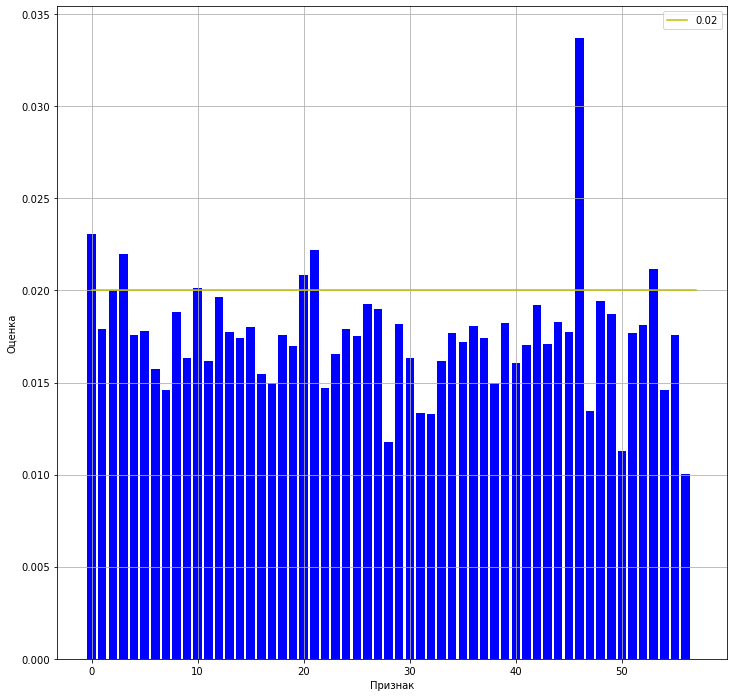

In [16]:
# Гистограмма важности признаков при предсказании целевых признаков
# из сбалансированного набора
best_y_balanced = plot_bar(clf, X, y_balanced, 'Features_y_balanced', 0.02)

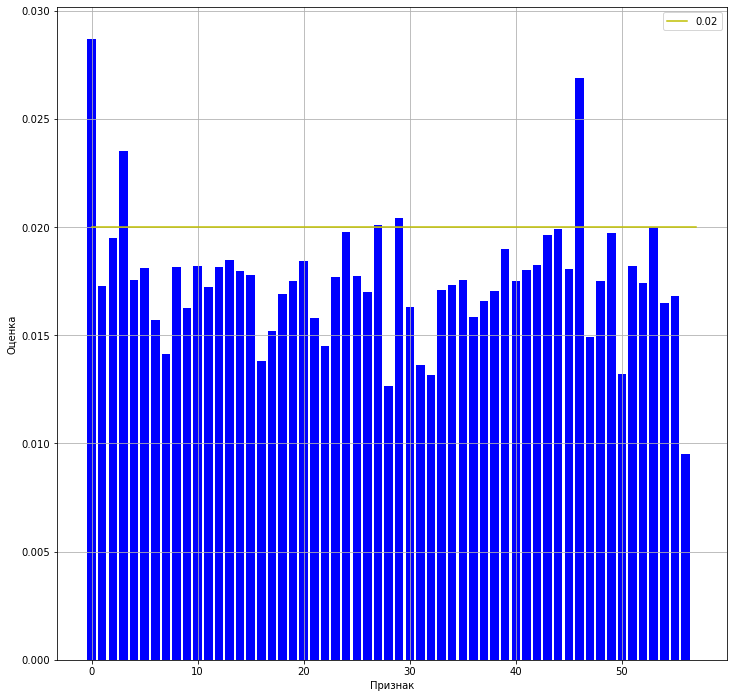

In [17]:
# Гистограмма важности признаков при предсказании целевых признаков
# из набора с преобладающим классом 0
best_y_bias_0 = plot_bar(clf, X, y_bias_0, 'Features_y_bias_0', 0.02)

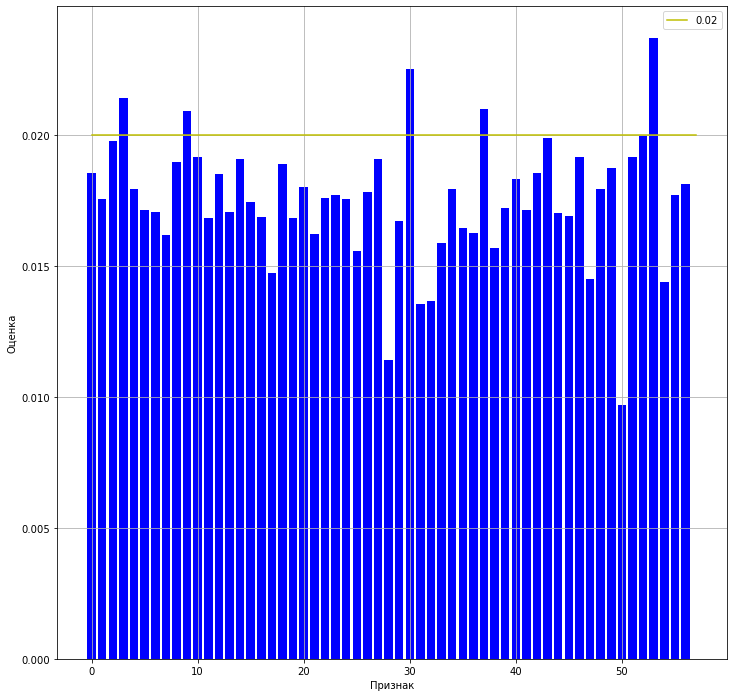

In [18]:
# Гистограмма важности признаков при предсказании целевых признаков
# из набора с преобладающим классом 1
best_y_bias_1 = plot_bar(clf, X, y_bias_1, 'Features_y_bias_1', 0.02)

In [19]:
# Самые важные признаки, участвующие в принятии 
# решения классификатором для сбалансированного набора
print(np.array(hobbies)[hobbies_balanced])
df[questions].iloc[:, best_y_balanced].head()

['History' 'Psychology' 'PC' 'Reading' 'Passive sport' 'Active sport'
 'Shopping' 'Science and technology' 'Pets']


,Daily events,Writing notes,Workaholism,Funniness,Giving,Compassion to animals,Life struggles,Interests or hobbies
0,2.0,5.0,4.0,5.0,4.0,5.0,1.0,3.0
1,3.0,4.0,5.0,3.0,2.0,4.0,1.0,3.0
2,1.0,5.0,3.0,2.0,5.0,4.0,4.0,5.0
3,4.0,4.0,5.0,1.0,1.0,2.0,3.0,3.0
4,3.0,2.0,3.0,3.0,3.0,3.0,2.0,3.0


In [20]:
# Самые важные признаки, участвующие в принятии 
# решения классификатором для набора с преобладающим классом 0
print(np.array(hobbies)[hobbies_bias_0])
df[questions].iloc[:, best_y_bias_0].head()

['Politics' 'Mathematics' 'Physics' 'Economy Management' 'Biology'
 'Chemistry' 'Geography' 'Medicine' 'Law' 'Cars' 'Art exhibitions'
 'Religion' 'Dancing' 'Musical instruments' 'Writing' 'Gardening'
 'Celebrities' 'Theatre' 'Adrenaline sports']


,Daily events,Workaholism,God,Charity,Life struggles,Interests or hobbies
0,2.0,4.0,1.0,2.0,1.0,3.0
1,3.0,5.0,1.0,1.0,1.0,3.0
2,1.0,3.0,5.0,3.0,4.0,5.0
3,4.0,5.0,4.0,3.0,3.0,3.0
4,3.0,3.0,5.0,3.0,2.0,3.0


In [21]:
# Самые важные признаки, участвующие в принятии 
# решения классификатором для набора с преобладающим классом 1
print(np.array(hobbies)[hobbies_bias_1])
df[questions].iloc[:, best_y_bias_1].head()

['Internet' 'Foreign languages' 'Countryside, outdoors' 'Fun with friends']


,Workaholism,Friends versus money,Number of friends,Socializing,Interests or hobbies
0,4.0,3.0,3,3.0,3.0
1,5.0,4.0,3,4.0,3.0
2,3.0,5.0,3,5.0,5.0
3,5.0,2.0,1,1.0,3.0
4,3.0,3.0,3,3.0,3.0


In [22]:
all_hobbies = np.where(np.sum(y_bias_1, axis=1) == y_bias_1.shape[1])
no_hobbies = np.where(np.sum(y_bias_1, axis=1) == 0)
print('Люди, которые имеют все популярные хобби сразу:', 
      len(all_hobbies[0]))
print('Люди, которые не имеют ни одного из популярных хобби:', 
      len(no_hobbies[0]))

Люди, которые имеют все популярные хобби сразу: 297
Люди, которые не имеют ни одного из популярных хобби: 8


In [23]:
all_hobbies = np.where(np.sum(y_balanced, axis=1) == y_balanced.shape[1])
no_hobbies = np.where(np.sum(y_balanced, axis=1) == 0)
print('Люди, которые имеют все сбалансированные хобби сразу:', 
      len(all_hobbies[0]))
print('Люди, которые не имеют ни одного из сбалансированных хобби:', 
      len(no_hobbies[0]))

Люди, которые имеют все сбалансированные хобби сразу: 1
Люди, которые не имеют ни одного из сбалансированных хобби: 8


In [24]:
all_hobbies = np.where(np.sum(y_bias_0, axis=1) == y_bias_0.shape[1])
no_hobbies = np.where(np.sum(y_bias_0, axis=1) == 0)
print('Люди, которые имеют все непопулярные хобби сразу:', 
      len(all_hobbies[0]))
print('Люди, которые не имеют ни одного из непопулярных хобби:', 
      len(no_hobbies[0]))

Люди, которые имеют все непопулярные хобби сразу: 0
Люди, которые не имеют ни одного из непопулярных хобби: 29


In [25]:
# Случайным образом выбирается 80% пользователей, отметивших все популярные хобби сразу,
# чтобы сократить их влияние на обучение
all_hobbies = np.where(np.sum(y_bias_1, axis=1) == y_bias_1.shape[1])[0]

popular_hobbies_fans = np.random.choice(all_hobbies, 
                                        replace=False, 
                                        size=int(np.round(0.8*all_hobbies.shape[0])))
len(popular_hobbies_fans)

238

In [26]:
X_bias_1 = np.delete(X, popular_hobbies_fans, axis=0)
y_bias_1 = np.delete(y_bias_1, popular_hobbies_fans, axis=0)

In [27]:
# Разделим выборки на обучающие и тренировочные
np.random.seed(42)

X_train, y_train, X_test, y_test = it_train(X, 
                                            y, 
                                            test_size=0.1)

X_balanced_train, y_balanced_train, X_balanced_test, y_balanced_test = it_train(X, 
                                                                                y_balanced, 
                                                                                test_size=0.1)

X_bias_0_train, y_bias_0_train, X_bias_0_test, y_bias_0_test = it_train(X, 
                                                                        y_bias_0, 
                                                                        test_size=0.1)

X_bias_1_train, y_bias_1_train, X_bias_1_test, y_bias_1_test = it_train(X_bias_1, 
                                                                        y_bias_1, 
                                                                        test_size=0.1)

# Стандартизируем данные
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

X_balanced_train = preprocessing.scale(X_balanced_train)
X_balanced_test = preprocessing.scale(X_balanced_test)

X_bias_0_train = preprocessing.scale(X_bias_0_train)
X_bias_0_test = preprocessing.scale(X_bias_0_test)

X_bias_1_train = preprocessing.scale(X_bias_1_train)
X_bias_1_test = preprocessing.scale(X_bias_1_test)

In [28]:
# Выведем отчет о качестве предсказаний, основывающихся на
# похожести респондентов 
print('FULL FEATURES REPORT:')
report_similarity(X_train, 
                  y_train, 
                  X_test, 
                  y_test, 
                  k=150)
print()
print('Y_BALANCED REPORT:')
report_similarity(X_balanced_train, 
                  y_balanced_train, 
                  X_balanced_test, 
                  y_balanced_test, 
                  k=150)

FULL FEATURES REPORT:
avg recall 0.3536325328935724
avg precision 0.49403462035040985
avg accuracy 0.6717575187969925

min recall 0.06666666666666667
max recall 1.0

min precision 0.1
max precision 1.0

min accuracy 0.25
max accuracy 0.875

Y_BALANCED REPORT:
avg recall 0.2348909657320872
avg precision 0.28976412995104583
avg accuracy 0.45794392523364463

min recall 0.0
max recall 1.0

min precision 0.0
max precision 1.0

min accuracy 0.0
max accuracy 0.8888888888888888


In [29]:
# Выведем отчет о качестве предсказаний, основывающихся на
# классификаторе случайного леса "из коробки"
clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

print('Y_BALANCED REPORT:')
report_classifier(clf, 
                  X_balanced_train, 
                  y_balanced_train, 
                  X_balanced_test, 
                  y_balanced_test)
print()
print('Y_BIAS_0 REPORT:')
report_classifier(clf, 
                  X_bias_0_train, 
                  y_bias_0_train, 
                  X_bias_0_test, 
                  y_bias_0_test)
print()
print('Y_BIAS_1 REPORT:')
report_classifier_neg(clf, 
                      X_bias_1_train,
                      y_bias_1_train,
                      X_bias_1_test, 
                      y_bias_1_test)

Y_BALANCED REPORT:
avg recall 0.40769915442812643
avg precision 0.551390743213173
avg accuracy 0.6199376947040499

min recall 0.0
max recall 1.0

min precision 0.0
max precision 1.0

min accuracy 0.0
max accuracy 1.0

Y_BIAS_0 REPORT:
avg recall 0.04501424501424501
avg precision 0.16666666666666666
avg accuracy 0.7678812415654515

min recall 0.0
max recall 1.0

min precision 0.0
max precision 1.0

min accuracy 0.42105263157894735
max accuracy 0.9473684210526315

Y_BIAS_1 REPORT:
avg recall 0.34210526315789475
avg precision 0.375
avg accuracy 0.6776315789473685

min recall 0.0
max recall 1.0

min precision 0.0
max precision 1.0

min accuracy 0.25
max accuracy 1.0


In [30]:
# Выведем отчет о качестве предсказаний, основывающихся на
# классификаторе полносвязной нейронной сети "из коробки"
clf = MLPClassifier(solver='lbfgs', random_state=42, max_iter=500)

print('Y_BALANCED REPORT:')
report_classifier(clf, 
                  X_balanced_train, 
                  y_balanced_train, 
                  X_balanced_test, 
                  y_balanced_test)
print()
print('Y_BIAS_0 REPORT:')
report_classifier(clf, 
                  X_bias_0_train, 
                  y_bias_0_train, 
                  X_bias_0_test, 
                  y_bias_0_test)
print()
print('Y_BIAS_1 REPORT:')
report_classifier_neg(clf, 
                      X_bias_1_train, 
                      y_bias_1_train, 
                      X_bias_1_test, 
                      y_bias_1_test)

Y_BALANCED REPORT:
avg recall 0.5085113484646193
avg precision 0.49503782821539827
avg accuracy 0.5607476635514018

min recall 0.0
max recall 1.0

min precision 0.0
max precision 1.0

min accuracy 0.2222222222222222
max accuracy 0.8888888888888888

Y_BIAS_0 REPORT:
avg recall 0.34229443396110065
avg precision 0.32214174714174715
avg accuracy 0.6644174538911383

min recall 0.0
max recall 1.0

min precision 0.0
max precision 1.0

min accuracy 0.3684210526315789
max accuracy 0.8947368421052632

Y_BIAS_1 REPORT:
avg recall 0.4122807017543859
avg precision 0.41885964912280704
avg accuracy 0.6019736842105263

min recall 0.0
max recall 1.0

min precision 0.0
max precision 1.0

min accuracy 0.0
max accuracy 1.0


# Тонкая настройка и выбор классификаторов

In [31]:
# Вручную создаем различные оценщики
def score_func_avg_acc(y, y_pred):
    accuracy_sum = 0
    for truth, prediction in zip(y, y_pred):
        accuracy_sum += accuracy_score(truth, prediction)
    return accuracy_sum / y.shape[0]

def score_func_avg_f1_score_pos(y, y_pred):
    f1_score_sum = 0
    for truth, prediction in zip(y, y_pred):
        f1_score_sum += f1_score(truth, 
                                 prediction, 
                                 pos_label=1, 
                                 zero_division=0)
    return f1_score_sum / y.shape[0]

def score_func_avg_f1_score_neg(y, y_pred):
    f1_score_sum = 0
    for truth, prediction in zip(y, y_pred):
        f1_score_sum += f1_score(truth, 
                                 prediction, 
                                 pos_label=0, 
                                 zero_division=0)
    return f1_score_sum / y.shape[0]

scorer_avg_acc = make_scorer(score_func_avg_acc)
scorer_avg_f1_pos = make_scorer(score_func_avg_f1_score_pos)
scorer_avg_f1_neg = make_scorer(score_func_avg_f1_score_neg)

In [32]:
# Итератор для разбияния выборки на каждом шаге
# кросс-валидации
k_fold_stratified = IterativeStratification(n_splits=5, order=1)

### Классификатор случайного леса

In [33]:
# Задаем классификатор для подбора параметров
clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

In [34]:
scores = cross_val_score(clf, 
                         X_balanced_train, 
                         y_balanced_train, 
                         cv=k_fold_stratified, 
                         scoring=scorer_avg_acc)
print("Средняя точность для сбалансированных целевых признаков:") 
print("Оценки на каждом этапе кросс-валдиации:", scores) 
print("Средняя оценка на кросс-валдиации:", "%.3f" % scores.mean())
print()

scores = cross_val_score(clf, 
                         X_bias_0_train, 
                         y_bias_0_train, 
                         cv=k_fold_stratified, 
                         scoring=scorer_avg_acc)
print("Средняя точность для целевых признаков предвзятых к 0:") 
print("Оценки на каждом этапе кросс-валдиации:", scores) 
print("Средняя оценка на кросс-валдиации:", "%.3f" % scores.mean())
print()

scores = cross_val_score(clf, 
                         X_bias_1_train, 
                         y_bias_1_train, 
                         cv=k_fold_stratified, 
                         scoring=scorer_avg_acc)
print("Средняя точность для целевых признаков предвзятых к 1:") 
print("Оценки на каждом этапе кросс-валдиации:", scores) 
print("Средняя оценка на кросс-валдиации:", "%.3f" % scores.mean())
print()

Средняя точность для сбалансированных целевых признаков:
Оценки на каждом этапе кросс-валдиации: [0.63545568 0.63428571 0.63004345 0.62614379 0.62698413]
Средняя оценка на кросс-валдиации: 0.631

Средняя точность для целевых признаков предвзятых к 0:
Оценки на каждом этапе кросс-валдиации: [0.76631579 0.77382646 0.74898785 0.75944272 0.76661654]
Средняя оценка на кросс-валдиации: 0.763

Средняя точность для целевых признаков предвзятых к 1:
Оценки на каждом этапе кросс-валдиации: [0.68933824 0.66544118 0.71616541 0.68566176 0.65992647]
Средняя оценка на кросс-валдиации: 0.683



In [35]:
scores = cross_val_score(clf, 
                         X_balanced_train, 
                         y_balanced_train, 
                         cv=k_fold_stratified, 
                         scoring=scorer_avg_f1_pos)
print("Средний f1 для сбалансированных целевых признаков:") 
print("Оценки на каждом этапе кросс-валдиации:", scores) 
print("Средняя оценка на кросс-валдиации:", "%.3f" % scores.mean())
print()

scores = cross_val_score(clf, 
                         X_bias_0_train, 
                         y_bias_0_train, 
                         cv=k_fold_stratified, 
                         scoring=scorer_avg_f1_pos)
print("Средний f1 для целевых признаков предвзятых к 0:") 
print("Оценки на каждом этапе кросс-валдиации:", scores) 
print("Средняя оценка на кросс-валдиации:", "%.3f" % scores.mean())
print()

scores = cross_val_score(clf, 
                         X_bias_1_train, 
                         y_bias_1_train, 
                         cv=k_fold_stratified, 
                         scoring=scorer_avg_f1_neg)
print("Средний f1 для целевых признаков предвзятых к 1:") 
print("Оценки на каждом этапе кросс-валдиации:", scores) 
print("Средняя оценка на кросс-валдиации:", "%.3f" % scores.mean())
print()

Средний f1 для сбалансированных целевых признаков:
Оценки на каждом этапе кросс-валдиации: [0.46496911 0.43475464 0.45222773 0.39680402 0.46974349]
Средняя оценка на кросс-валдиации: 0.444

Средний f1 для целевых признаков предвзятых к 0:
Оценки на каждом этапе кросс-валдиации: [0.08330308 0.05643702 0.09399943 0.06696644 0.07959257]
Средняя оценка на кросс-валдиации: 0.076

Средний f1 для целевых признаков предвзятых к 1:
Оценки на каждом этапе кросс-валдиации: [0.36519608 0.42843137 0.42769608 0.35308642 0.42238806]
Средняя оценка на кросс-валдиации: 0.399



In [36]:
# Задаем варианты гиперпараметров, которые
# будут подбираться для классификаторов
params_to_test = {
    'criterion':['gini', 'entropy'],
    'max_depth':[*np.arange(10, 16), None],
    'min_samples_leaf':np.arange(1, 4),
    'min_samples_split':[2, 3, 5, 6],
    'max_features':['sqrt', 'log2', None],
    'class_weight':[None, 'balanced'],
}

In [37]:
grid_search = GridSearchCV(clf, 
                           param_grid=params_to_test, 
                           cv=k_fold_stratified, 
                           scoring=scorer_avg_f1_pos,
                           verbose=1)
grid_search.fit(X_balanced_train, y_balanced_train)
clf_tuned_balanced = grid_search.best_estimator_
grid_search.best_estimator_

Fitting 5 folds for each of 1008 candidates, totalling 5040 fits


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features=None, min_samples_split=6,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [38]:
grid_search = GridSearchCV(clf, 
                           param_grid=params_to_test, 
                           cv=k_fold_stratified, 
                           scoring=scorer_avg_f1_pos,
                           verbose=1)
grid_search.fit(X_bias_0_train, y_bias_0_train)
clf_tuned_bias_0 = grid_search.best_estimator_
grid_search.best_estimator_

Fitting 5 folds for each of 1008 candidates, totalling 5040 fits


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features=None, min_samples_leaf=3,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [39]:
grid_search = GridSearchCV(clf, 
                           param_grid=params_to_test, 
                           cv=k_fold_stratified, 
                           scoring=scorer_avg_f1_neg,
                           verbose=1)
grid_search.fit(X_bias_1_train, y_bias_1_train)
clf_tuned_bias_1 = grid_search.best_estimator_
grid_search.best_estimator_

Fitting 5 folds for each of 1008 candidates, totalling 5040 fits


RandomForestClassifier(max_depth=10, max_features=None, min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [40]:
# Проверяем оценку классификатора с подобранными параметрами
# на кросс-валидации для сбалансированного набора
scores = cross_val_score(clf_tuned_balanced, 
                         X_balanced_train, 
                         y_balanced_train, 
                         cv=k_fold_stratified, 
                         scoring=scorer_avg_acc)
print("Средняя точность для сбалансированных целевых признаков:") 
print("Оценки на каждом этапе кросс-валдиации:", scores) 
print("Средняя оценка на кросс-валдиации:", "%.3f" % scores.mean())
print()

scores = cross_val_score(clf_tuned_balanced, 
                         X_balanced_train, 
                         y_balanced_train, 
                         cv=k_fold_stratified, 
                         scoring=scorer_avg_f1_pos)
print("Средний f1 для сбалансированных целевых признаков:")
print("Оценки на каждом этапе кросс-валдиации:", scores) 
print("Средняя оценка на кросс-валдиации:", "%.3f" % scores.mean())

Средняя точность для сбалансированных целевых признаков:
Оценки на каждом этапе кросс-валдиации: [0.61296296 0.63267974 0.62901235 0.63527935 0.60326428]
Средняя оценка на кросс-валдиации: 0.623

Средний f1 для сбалансированных целевых признаков:
Оценки на каждом этапе кросс-валдиации: [0.51054414 0.55269764 0.49535298 0.52183414 0.52418737]
Средняя оценка на кросс-валдиации: 0.521


In [41]:
# Проверяем оценку классификатора с подобранными параметрами
# на кросс-валидации для набора с преобладающим классом 0
scores = cross_val_score(clf_tuned_bias_0, 
                         X_bias_0_train, 
                         y_bias_0_train, 
                         cv=k_fold_stratified, 
                         scoring=scorer_avg_acc)
print("Средняя точность для целевых признаков предвзятых к 0:") 
print("Оценки на каждом этапе кросс-валдиации:", scores) 
print("Средняя оценка на кросс-валдиации:", "%.3f" % scores.mean())
print()

scores = cross_val_score(clf_tuned_bias_0, 
                         X_bias_0_train, 
                         y_bias_0_train, 
                         cv=k_fold_stratified, 
                         scoring=scorer_avg_f1_pos)
print("Средний f1 для целевых признаков предвзятых к 0:") 
print("Оценки на каждом этапе кросс-валдиации:", scores) 
print("Средняя оценка на кросс-валдиации:", "%.3f" % scores.mean())

Средняя точность для целевых признаков предвзятых к 0:
Оценки на каждом этапе кросс-валдиации: [0.64992481 0.63458647 0.65022556 0.67849624 0.66848155]
Средняя оценка на кросс-валдиации: 0.656

Средний f1 для целевых признаков предвзятых к 0:
Оценки на каждом этапе кросс-валдиации: [0.35562384 0.28686805 0.34949644 0.29429076 0.2901868 ]
Средняя оценка на кросс-валдиации: 0.315


In [42]:
# Проверяем оценку классификатора с подобранными параметрами
# на кросс-валидации для набора с преобладающим классом 1
scores = cross_val_score(clf_tuned_bias_1, 
                         X_bias_1_train, 
                         y_bias_1_train, 
                         cv=k_fold_stratified, 
                         scoring=scorer_avg_acc)
print("Средняя точность для целевых признаков предвзятых к 1:") 
print("Оценки на каждом этапе кросс-валдиации:", scores) 
print("Средняя оценка на кросс-валдиации:", "%.3f" % scores.mean())
print()

scores = cross_val_score(clf_tuned_bias_1, 
                         X_bias_1_train, 
                         y_bias_1_train, 
                         cv=k_fold_stratified, 
                         scoring=scorer_avg_f1_neg)
print("Средний f1 для целевых признаков предвзятых к 1:") 
print("Оценки на каждом этапе кросс-валдиации:", scores) 
print("Средняя оценка на кросс-валдиации:", "%.3f" % scores.mean())

Средняя точность для целевых признаков предвзятых к 1:
Оценки на каждом этапе кросс-валдиации: [0.69301471 0.6875     0.69360902 0.65992647 0.66727941]
Средняя оценка на кросс-валдиации: 0.680

Средний f1 для целевых признаков предвзятых к 1:
Оценки на каждом этапе кросс-валдиации: [0.39828431 0.40465686 0.38897243 0.40686275 0.43970588]
Средняя оценка на кросс-валдиации: 0.408


### Классификатор на основе полносвязной нейронной сети

In [43]:
# Задаем классификатор для подбора параметров
clf_mlp = MLPClassifier(random_state=42, 
                        max_iter=1000,
                        learning_rate_init=0.02, 
                        early_stopping=True, 
                        n_iter_no_change=50)

In [44]:
scores = cross_val_score(clf_mlp, 
                         X_balanced_train, 
                         y_balanced_train, 
                         cv=k_fold_stratified, 
                         scoring=scorer_avg_acc,
                         n_jobs=-1)
print("Средняя точность для сбалансированных целевых признаков:") 
print("Оценки на каждом этапе кросс-валдиации:", scores) 
print("Средняя оценка на кросс-валдиации:", "%.3f" % scores.mean())
print()

scores = cross_val_score(clf_mlp, 
                         X_bias_0_train, 
                         y_bias_0_train, 
                         cv=k_fold_stratified, 
                         scoring=scorer_avg_acc,
                         n_jobs=-1)
print("Средняя точность для целевых признаков предвзятых к 0:") 
print("Оценки на каждом этапе кросс-валдиации:", scores) 
print("Средняя оценка на кросс-валдиации:", "%.3f" % scores.mean())
print()

scores = cross_val_score(clf_mlp, 
                         X_bias_1_train, 
                         y_bias_1_train, 
                         cv=k_fold_stratified, 
                         scoring=scorer_avg_acc,
                         n_jobs=-1)
print("Средняя точность для целевых признаков предвзятых к 1:") 
print("Оценки на каждом этапе кросс-валдиации:", scores) 
print("Средняя оценка на кросс-валдиации:", "%.3f" % scores.mean())
print()

Средняя точность для сбалансированных целевых признаков:
Оценки на каждом этапе кросс-валдиации: [0.60640301 0.6007326  0.61079724 0.61581921 0.60688759]
Средняя оценка на кросс-валдиации: 0.608

Средняя точность для целевых признаков предвзятых к 0:
Оценки на каждом этапе кросс-валдиации: [0.76270677 0.73252804 0.75232198 0.74593892 0.77602975]
Средняя оценка на кросс-валдиации: 0.754

Средняя точность для целевых признаков предвзятых к 1:
Оценки на каждом этапе кросс-валдиации: [0.66021127 0.65073529 0.64849624 0.67105263 0.64285714]
Средняя оценка на кросс-валдиации: 0.655



In [45]:
scores = cross_val_score(clf_mlp, 
                         X_balanced_train, 
                         y_balanced_train, 
                         cv=k_fold_stratified, 
                         scoring=scorer_avg_f1_pos,
                         n_jobs=-1)
print("Средний f1 для сбалансированных целевых признаков:") 
print("Оценки на каждом этапе кросс-валдиации:", scores) 
print("Средняя оценка на кросс-валдиации:", "%.3f" % scores.mean())
print()

scores = cross_val_score(clf_mlp, 
                         X_bias_0_train, 
                         y_bias_0_train, 
                         cv=k_fold_stratified, 
                         scoring=scorer_avg_f1_pos,
                         n_jobs=-1)
print("Средний f1 для целевых признаков предвзятых к 0:") 
print("Оценки на каждом этапе кросс-валдиации:", scores) 
print("Средняя оценка на кросс-валдиации:", "%.3f" % scores.mean())
print()

scores = cross_val_score(clf_mlp, 
                         X_bias_1_train, 
                         y_bias_1_train, 
                         cv=k_fold_stratified, 
                         scoring=scorer_avg_f1_neg,
                         n_jobs=-1)
print("Средний f1 для целевых признаков предвзятых к 1:") 
print("Оценки на каждом этапе кросс-валдиации:", scores) 
print("Средняя оценка на кросс-валдиации:", "%.3f" % scores.mean())
print()

Средний f1 для сбалансированных целевых признаков:
Оценки на каждом этапе кросс-валдиации: [0.49882667 0.48800644 0.48165266 0.51765606 0.50521346]
Средняя оценка на кросс-валдиации: 0.498

Средний f1 для целевых признаков предвзятых к 0:
Оценки на каждом этапе кросс-валдиации: [0.30339703 0.25774111 0.25412546 0.24867019 0.09363814]
Средняя оценка на кросс-валдиации: 0.232

Средний f1 для целевых признаков предвзятых к 1:
Оценки на каждом этапе кросс-валдиации: [0.44264706 0.35984848 0.468037   0.46652661 0.42562189]
Средняя оценка на кросс-валдиации: 0.433



In [46]:
# Задаем варианты гиперпараметров, которые
# будут подбираться для классификаторов
parameter_space = {
    'hidden_layer_sizes': [(50,), 
                           (100, ), 
                           (100, 100,), 
                           (120, 120), 
                           (100, 50, 50), 
                           (150, 150), 
                           (150, 120)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'adam'],
    'alpha': [0.0001, 0.01, 0.04, 0.05, 0.06, 0.1],
}

In [47]:
grid_search = GridSearchCV(clf_mlp, 
                           param_grid=parameter_space, 
                           cv=k_fold_stratified, 
                           scoring=scorer_avg_f1_pos,
                           verbose=1,
                           n_jobs=-1)
grid_search.fit(X_balanced_train, y_balanced_train)
clf_mlp_tuned_balanced = grid_search.best_estimator_
grid_search.best_estimator_

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


MLPClassifier(activation='tanh', alpha=0.06, early_stopping=True,
              hidden_layer_sizes=(100, 50, 50), learning_rate_init=0.02,
              max_iter=1000, n_iter_no_change=50, random_state=42)

In [48]:
grid_search = GridSearchCV(clf_mlp, 
                           param_grid=parameter_space, 
                           cv=k_fold_stratified, 
                           scoring=scorer_avg_f1_pos,
                           verbose=1,
                           n_jobs=-1)
grid_search.fit(X_bias_0_train, y_bias_0_train)
clf_mlp_tuned_bias_0 = grid_search.best_estimator_
grid_search.best_estimator_

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


MLPClassifier(alpha=0.01, early_stopping=True, learning_rate_init=0.02,
              max_iter=1000, n_iter_no_change=50, random_state=42,
              solver='lbfgs')

In [49]:
grid_search = GridSearchCV(clf_mlp, 
                           param_grid=parameter_space, 
                           cv=k_fold_stratified, 
                           scoring=scorer_avg_f1_neg,
                           verbose=1,
                           n_jobs=-1)
grid_search.fit(X_bias_1_train, y_bias_1_train)
clf_mlp_tuned_bias_1 = grid_search.best_estimator_
grid_search.best_estimator_

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


MLPClassifier(alpha=0.1, early_stopping=True, hidden_layer_sizes=(150, 120),
              learning_rate_init=0.02, max_iter=1000, n_iter_no_change=50,
              random_state=42)

In [50]:
# Проверяем оценку классификатора с подобранными параметрами
# на кросс-валидации для сбалансированного набора
scores = cross_val_score(clf_mlp_tuned_balanced, 
                         X_balanced_train, 
                         y_balanced_train, 
                         cv=k_fold_stratified, 
                         scoring=scorer_avg_acc,
                         n_jobs=-1)
print("Средняя точность для сбалансированных целевых признаков:") 
print("Оценки на каждом этапе кросс-валдиации:", scores) 
print("Средняя оценка на кросс-валдиации:", "%.3f" % scores.mean())
print()

scores = cross_val_score(clf_mlp_tuned_balanced, 
                         X_balanced_train, 
                         y_balanced_train, 
                         cv=k_fold_stratified, 
                         scoring=scorer_avg_f1_pos,
                         n_jobs=-1)
print("Средний f1 для сбалансированных целевых признаков:")
print("Оценки на каждом этапе кросс-валдиации:", scores) 
print("Средняя оценка на кросс-валдиации:", "%.3f" % scores.mean())

Средняя точность для сбалансированных целевых признаков:
Оценки на каждом этапе кросс-валдиации: [0.61016949 0.62590401 0.61757106 0.58739076 0.60401891]
Средняя оценка на кросс-валдиации: 0.609

Средний f1 для сбалансированных целевых признаков:
Оценки на каждом этапе кросс-валдиации: [0.46550214 0.50867296 0.4989153  0.47313023 0.45882501]
Средняя оценка на кросс-валдиации: 0.481


In [51]:
# Проверяем оценку классификатора с подобранными параметрами
# на кросс-валидации для набора с преобладающим классом 0
scores = cross_val_score(clf_mlp_tuned_bias_0, 
                         X_bias_0_train, 
                         y_bias_0_train, 
                         cv=k_fold_stratified, 
                         scoring=scorer_avg_acc,
                         n_jobs=-1)
print("Средняя точность для целевых признаков предвзятых к 0:") 
print("Оценки на каждом этапе кросс-валдиации:", scores) 
print("Средняя оценка на кросс-валдиации:", "%.3f" % scores.mean())
print()

scores = cross_val_score(clf_mlp_tuned_bias_0, 
                         X_bias_0_train, 
                         y_bias_0_train, 
                         cv=k_fold_stratified, 
                         scoring=scorer_avg_f1_pos,
                         n_jobs=-1)
print("Средний f1 для целевых признаков предвзятых к 0:") 
print("Оценки на каждом этапе кросс-валдиации:", scores) 
print("Средняя оценка на кросс-валдиации:", "%.3f" % scores.mean())

Средняя точность для целевых признаков предвзятых к 0:
Оценки на каждом этапе кросс-валдиации: [0.67836257 0.68269812 0.69214937 0.67729323 0.68842105]
Средняя оценка на кросс-валдиации: 0.684

Средний f1 для целевых признаков предвзятых к 0:
Оценки на каждом этапе кросс-валдиации: [0.31669615 0.31905965 0.31109788 0.28879266 0.31654989]
Средняя оценка на кросс-валдиации: 0.310


In [52]:
# Проверяем оценку классификатора с подобранными параметрами
# на кросс-валидации для набора с преобладающим классом 1
scores = cross_val_score(clf_mlp_tuned_bias_1, 
                         X_bias_1_train, 
                         y_bias_1_train, 
                         cv=k_fold_stratified, 
                         scoring=scorer_avg_acc,
                         n_jobs=-1)
print("Средняя точность для целевых признаков предвзятых к 1:") 
print("Оценки на каждом этапе кросс-валдиации:", scores) 
print("Средняя оценка на кросс-валдиации:", "%.3f" % scores.mean())
print()

scores = cross_val_score(clf_mlp_tuned_bias_1, 
                         X_bias_1_train, 
                         y_bias_1_train, 
                         cv=k_fold_stratified, 
                         scoring=scorer_avg_f1_neg,
                         n_jobs=-1)
print("Средний f1 для целевых признаков предвзятых к 1:") 
print("Оценки на каждом этапе кросс-валдиации:", scores) 
print("Средняя оценка на кросс-валдиации:", "%.3f" % scores.mean())

Средняя точность для целевых признаков предвзятых к 1:
Оценки на каждом этапе кросс-валдиации: [0.66729323 0.62683824 0.63419118 0.65217391 0.64738806]
Средняя оценка на кросс-валдиации: 0.646

Средний f1 для целевых признаков предвзятых к 1:
Оценки на каждом этапе кросс-валдиации: [0.47259259 0.46111111 0.47712895 0.47205882 0.48515815]
Средняя оценка на кросс-валдиации: 0.474


#### Отчеты о работе классификатора случайный лес на тестовых данных после подбора параметров для каждой из категорий целевых признаков

In [53]:
print("Классификатор без тонкой настройки:")
report_classifier(clf, 
                  X_balanced_train, 
                  y_balanced_train, 
                  X_balanced_test, 
                  y_balanced_test)
print()

print("Классификатор с подбором гиперпараметров:")
report_classifier(clf_tuned_balanced, 
                  X_balanced_train, 
                  y_balanced_train, 
                  X_balanced_test, 
                  y_balanced_test)

Классификатор без тонкой настройки:
avg recall 0.40769915442812643
avg precision 0.551390743213173
avg accuracy 0.6199376947040499

min recall 0.0
max recall 1.0

min precision 0.0
max precision 1.0

min accuracy 0.0
max accuracy 1.0

Классификатор с подбором гиперпараметров:
avg recall 0.542545616377392
avg precision 0.5562305295950154
avg accuracy 0.6053997923156802

min recall 0.0
max recall 1.0

min precision 0.0
max precision 1.0

min accuracy 0.1111111111111111
max accuracy 1.0


In [54]:
print("Классификатор без тонкой настройки:")
report_classifier(clf, 
                  X_bias_0_train, 
                  y_bias_0_train, 
                  X_bias_0_test, 
                  y_bias_0_test)
print()

print("Классификатор с подбором гиперпараметров:")
report_classifier(clf_tuned_bias_0, 
                  X_bias_0_train, 
                  y_bias_0_train, 
                  X_bias_0_test, 
                  y_bias_0_test)

Классификатор без тонкой настройки:
avg recall 0.04501424501424501
avg precision 0.16666666666666666
avg accuracy 0.7678812415654515

min recall 0.0
max recall 1.0

min precision 0.0
max precision 1.0

min accuracy 0.42105263157894735
max accuracy 0.9473684210526315

Классификатор с подбором гиперпараметров:
avg recall 0.3798340548340549
avg precision 0.2919994116826696
avg accuracy 0.6257309941520469

min recall 0.0
max recall 1.0

min precision 0.0
max precision 0.8333333333333334

min accuracy 0.2631578947368421
max accuracy 0.8947368421052632


In [55]:
print("Классификатор без тонкой настройки:")
report_classifier_neg(clf, 
                      X_bias_1_train, 
                      y_bias_1_train, 
                      X_bias_1_test, 
                      y_bias_1_test)
print()

print("Классификатор с подбором гиперпараметров:")
report_classifier_neg(clf_tuned_bias_1, 
                      X_bias_1_train, 
                      y_bias_1_train, 
                      X_bias_1_test, 
                      y_bias_1_test)

Классификатор без тонкой настройки:
avg recall 0.34210526315789475
avg precision 0.375
avg accuracy 0.6776315789473685

min recall 0.0
max recall 1.0

min precision 0.0
max precision 1.0

min accuracy 0.25
max accuracy 1.0

Классификатор с подбором гиперпараметров:
avg recall 0.3728070175438596
avg precision 0.40131578947368424
avg accuracy 0.6743421052631579

min recall 0.0
max recall 1.0

min precision 0.0
max precision 1.0

min accuracy 0.25
max accuracy 1.0


#### Отчеты о работе классификатора на основе полносвязной сети на тестовых данных после подбора параметров для каждой из категорий целевых признаков

In [56]:
print("Классификатор без тонкой настройки:")
report_classifier(clf_mlp, 
                  X_balanced_train, 
                  y_balanced_train, 
                  X_balanced_test, 
                  y_balanced_test)
print()

print("Классификатор с подбором гиперпараметров:")
report_classifier(clf_mlp_tuned_balanced, 
                  X_balanced_train, 
                  y_balanced_train, 
                  X_balanced_test, 
                  y_balanced_test)

Классификатор без тонкой настройки:
avg recall 0.55188028482421
avg precision 0.5711244622459574
avg accuracy 0.6323987538940811

min recall 0.0
max recall 1.0

min precision 0.0
max precision 1.0

min accuracy 0.2222222222222222
max accuracy 1.0

Классификатор с подбором гиперпараметров:
avg recall 0.5727859368046283
avg precision 0.5688807298620382
avg accuracy 0.6209761163032191

min recall 0.0
max recall 1.0

min precision 0.0
max precision 1.0

min accuracy 0.2222222222222222
max accuracy 1.0


In [57]:
print("Классификатор без тонкой настройки:")
report_classifier(clf_mlp, 
                  X_bias_0_train, 
                  y_bias_0_train, 
                  X_bias_0_test, 
                  y_bias_0_test)
print()

print("Классификатор с подбором гиперпараметров:")
report_classifier(clf_mlp_tuned_bias_0, 
                  X_bias_0_train, 
                  y_bias_0_train, 
                  X_bias_0_test, 
                  y_bias_0_test)

Классификатор без тонкой настройки:
avg recall 0.06360429693763028
avg precision 0.2250712250712251
avg accuracy 0.7656320287899225

min recall 0.0
max recall 0.5

min precision 0.0
max precision 1.0

min accuracy 0.47368421052631576
max accuracy 0.9473684210526315

Классификатор с подбором гиперпараметров:
avg recall 0.3462691629358296
avg precision 0.31208174541507877
avg accuracy 0.6644174538911386

min recall 0.0
max recall 1.0

min precision 0.0
max precision 1.0

min accuracy 0.2631578947368421
max accuracy 0.8947368421052632


In [58]:
print("Классификатор без тонкой настройки:")
report_classifier_neg(clf_mlp, 
                      X_bias_1_train, 
                      y_bias_1_train, 
                      X_bias_1_test, 
                      y_bias_1_test)
print()

print("Классификатор с подбором гиперпараметров:")
report_classifier_neg(clf_mlp_tuned_bias_1, 
                      X_bias_1_train, 
                      y_bias_1_train, 
                      X_bias_1_test, 
                      y_bias_1_test)

Классификатор без тонкой настройки:
avg recall 0.5526315789473685
avg precision 0.49561403508771934
avg accuracy 0.6743421052631579

min recall 0.0
max recall 1.0

min precision 0.0
max precision 1.0

min accuracy 0.0
max accuracy 1.0

Классификатор с подбором гиперпараметров:
avg recall 0.34868421052631576
avg precision 0.40789473684210525
avg accuracy 0.6414473684210527

min recall 0.0
max recall 1.0

min precision 0.0
max precision 1.0

min accuracy 0.0
max accuracy 1.0


## Сохранение модели

In [59]:
# Обучаем классификаторы на всех данных
X_scaled = preprocessing.scale(X)
X_scaled_bias_1 = preprocessing.scale(X_bias_1)

clf_mlp_tuned_balanced.fit(X_scaled, y_balanced)
clf_mlp_tuned_bias_0.fit(X_scaled, y_bias_0)
clf_mlp_tuned_bias_1.fit(X_scaled_bias_1, y_bias_1)

MLPClassifier(alpha=0.1, early_stopping=True, hidden_layer_sizes=(150, 120),
              learning_rate_init=0.02, max_iter=1000, n_iter_no_change=50,
              random_state=42)

In [60]:
# Сохраняем лучшие классификаторы на диск
dump(clf_mlp_tuned_balanced, 'model_balanced.joblib')
dump(clf_mlp_tuned_bias_0, 'model_bias_0.joblib') 
dump(clf_mlp_tuned_bias_1, 'model_bias_1.joblib') 

['model_bias_1.joblib']